# Model construction

# 0. Import Data and Modules

In [22]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
import xgboost as xgb
from sklearn import metrics
from datetime import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [3]:
os.chdir("C:/Users/TonyG/Documents/GitHub/bads/kaggle") # Tony
#os.chdir("C:/Users/erin-/Documents/bads/kaggle") # Erin
#os.chdir("C:/Users/gotschat/Documents") # Server
data = pd.read_pickle('./data/known_cleaned_w_dummies')
X = data.drop("return", axis = 1)
y = data["return"]
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98928 entries, 1 to 100000
Columns: 132 entries, item_id to user_state_Thuringia
dtypes: float64(3), int64(4), uint8(125)
memory usage: 17.8 MB


### For Preliminary version only: Create test and train sets based on the known dataset via random splitting

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 314)

## 1. Boosted Trees 

### 1.1 with Random Search CV and custom score function

In [5]:
def cost_custom_score(estimator, X, y):
    zeros = np.zeros(y.shape[0])
    hat = 1 * estimator.predict(X)
    val = X.loc[:, "item_price"]
    score = -1 * (np.fmax(np.array(y - hat), zeros) * (0.5 + 0.1 * val) +
                 np.fmax(np.array(hat - y), zeros) * (0.5 * val))
    return score.sum()

In [6]:
def cost_custom_eval(y_true, y_test, X, relative = False):
    '''Custom Evaluation based on cost matrix
    relative: True: return TP, FP, FN, TN, False: return the aggregated score, i.e. TP + TN + FP + FN
    '''
    y_true = 1 * y_true # Convert to integer
    y_test = 1 * y_test
    
    zeros = np.zeros(y_true.shape[0]) # zeros for calculation
    val = X.loc[:, "item_price"] # item_price of item 
    
    TP, TN = np.array([0, 0]) # TP and TN are always 0
    
    # Calculate FP
    FP = np.fmax(np.array(y_test - y_true), zeros) * (0.5 * val)
    
    # Calculate FN
    FN = np.fmax(np.array(y_true - y_test), zeros) * (0.5 + 0.1 * val)
    
    # If clause for relative parameter
    if(relative == True):
        return(np.array([TP, FP.sum(), FN.sum(), TN]))
    else:
        return(np.sum([FP, FN]))
    
    #score = 1 * (np.fmax(np.array(y_true - y_test), zeros) * (0.5 + 0.1 * val) +
    #             np.fmax(np.array(y_test - y_true), zeros) * (0.5 * val))
    #return score.sum()

### Reference Model Performance

In [14]:
# Train a simple boosted tree classifier and calculate the custom score for this model using the X_test and y_test hold out
ref_mod = xgb.XGBClassifier(objective = "binary:logistic")
ref_mod.fit(X_train, y_train)

D:\Program Files\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:23:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [15]:
base_perf = cost_custom_eval(y_test, 1 * ref_mod.predict(X_test), X_test)
base_perf

253842.318

### Cross-Validation

In [29]:
fixed_boosting_rnds = True # Implemented a switch whether number of boosting rounds shoul be tuned as well
param_grid = {"max_depth" : np.arange(5,80, step = 5), # maximum number of nodes for each base learner
             "eta" : stats.uniform(0.05, 0.70), # Learning rate
             "gamma" : stats.uniform(0.05, 3), # Minimum node impurity gain required to attempt a split
             "lambda" : stats.uniform(0, 8), # L2 regularization coefficent
             "colsample_bytree" : np.arange(0.2, 1, step = 0.1), # proportion of features considered for each base learner
             "subsample" : np.arange(0.5, 1, step = 0.1), # proportion of training data subsampled for each base learner
             "n_estimators" : np.where(fixed_boosting_rnds, 15, np.arange(10, 40, step = 5))} # Number of boosting rounds; will be inreased for the winner
    
gbm = xgb.XGBClassifier(objective = "binary:logistic") # initiate estimator
metric = "recall" # Scoring metric used during training
n = 600 # number of candidates to consider
fold = 5 # number of folds for cv
n * fold # number of fits

3000

In [30]:
randomized_auc = RandomizedSearchCV(estimator = gbm, n_iter = n, cv = fold, scoring = metric,
                                    param_distributions = param_grid, verbose = 1, random_state = 321,
                                   n_jobs = -1, refit = True)
randomized_auc.fit(X_train,y_train)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 39.4min
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed: 105.5min
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed: 201.6min
[Parallel(n_jobs=-1)]: Done 1170 tasks      | elapsed: 333.8min
[Parallel(n_jobs=-1)]: Done 1720 tasks      | elapsed: 487.7min
[Parallel(n_jobs=-1)]: Done 2370 tasks      | elapsed: 696.9min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 888.2min finished
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:23:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000FBC807A430>,
                                        'lambda': <scipy

In [31]:
print("Best Parameters:", randomized_auc.best_params_)
print("Best Score:", randomized_auc.best_score_ * (-1))

Best Parameters: {'colsample_bytree': 0.9000000000000001, 'eta': 0.12902867757724626, 'gamma': 1.9479508080081354, 'lambda': 2.7667137866636837, 'max_depth': 5, 'n_estimators': 15, 'subsample': 0.7999999999999999}
Best Score: -0.7402062318066368


If trained on server:

In [7]:
#Server = 1
switch = 0
param_server = np.where(switch == 1, ["eta", "lambda"], ["learning_rate", "reg_lambda"])

if(switch == 1):
    params = randomized_auc.best_params_
else:
    # copy paste saved dictionary if not on server
    params = {'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.2, 'gamma': 1.1325372296171017, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.054581921092903024, 'max_delta_step': 0, 'max_depth': 25, 'min_child_weight': 1, 'monotone_constraints': '()', 'n_estimators': 200, 'n_jobs': 40, 'num_parallel_tree': 1, 'random_state': 321, 'reg_alpha': 0, 'reg_lambda': 2.480681687701786, 'scale_pos_weight': 1, 'subsample': 0.8999999999999999, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}	

eval_set = [(X_train, y_train), (X_test, y_test)] # Evaluation set for early stopping

randomized_auc = xgb.XGBClassifier(objective = "binary:logistic",
                                   max_depth = params["max_depth"],
                                   learning_rate =  params[param_server[0]],
                                   gamma = params["gamma"],
                                   reg_lambda = params[param_server[1]],
                                   colsample_bytree = params["colsample_bytree"],
                                   subsample = params["subsample"],
                                   n_estimators = 300, # Train with higher number of boosting rounds as in the cv part
                                   random_state = 321)
randomized_auc.fit(X_train, y_train, early_stopping_rounds = 10, eval_metric = "aucpr", eval_set = eval_set,
                  verbose = True) # Enable earlier stopping when within 10 rounds no improvement is observed using auc as evaluation metric

D:\Program Files\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-aucpr:0.71809	validation_1-aucpr:0.55034
[1]	validation_0-aucpr:0.71667	validation_1-aucpr:0.55156
[2]	validation_0-aucpr:0.73338	validation_1-aucpr:0.58318
[3]	validation_0-aucpr:0.76848	validation_1-aucpr:0.60412
[4]	validation_0-aucpr:0.82498	validation_1-aucpr:0.63401
[5]	validation_0-aucpr:0.82491	validation_1-aucpr:0.63423
[6]	validation_0-aucpr:0.82886	validation_1-aucpr:0.63574
[7]	validation_0-aucpr:0.84593	validation_1-aucpr:0.63410
[8]	validation_0-aucpr:0.84904	validation_1-aucpr:0.63758
[9]	validation_0-aucpr:0.87032	validation_1-aucpr:0.65476
[10]	validation_0-aucpr:0.87225	validation_1-aucpr:0.65208
[11]	validation_0-aucpr:0.87950	validation_1-aucpr:0.65324
[12]	validation_0-aucpr:0.87913	validation_1-aucpr:0.65332
[13]	validation_0-aucpr:0.88268	validation_1-aucpr:0.65885
[14]	validation_0-aucpr:0.87585	validation_1-aucpr:0.66022
[15]	validation_0-aucpr:0.88143	validation_1-aucpr:0.66440
[16]	validation_0-aucpr:0.88637	validation_1-aucpr:0.66718
[17]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2,
              gamma=1.1325372296171017, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.054581921092903024,
              max_delta_step=0, max_depth=25, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=8,
              num_parallel_tree=1, random_state=321, reg_alpha=0,
              reg_lambda=2.480681687701786, scale_pos_weight=1,
              subsample=0.8999999999999999, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [9]:
randomized_auc.best_iteration, randomized_auc.best_score

(40, 0.674334)

Display evaluation performance during training

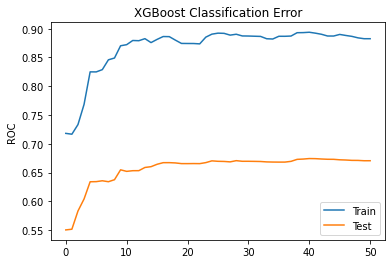

In [8]:
from matplotlib import pyplot
results = randomized_auc.evals_result()
epochs = len(results['validation_0']['aucpr'])
x_axis = range(0, epochs)
# plot roc
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['aucpr'], label='Train')
ax.plot(x_axis, results['validation_1']['aucpr'], label='Test')
ax.legend()
pyplot.ylabel('ROC')
pyplot.title('XGBoost Classification Error')
pyplot.show()

### Find optimal cost-cutoff

First let us inspect, whether our model is well calibrated.

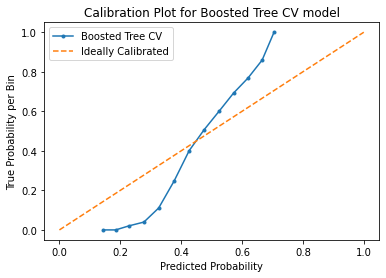

In [9]:
# Calibration curve for LogitCV
from sklearn.calibration import calibration_curve

# Get prediction probabilities
pred_proba = randomized_auc.predict_proba(X_test)[:,1]

# Calculate calibration using calibration_curve function
prob_true, prob_pred = calibration_curve(y_test, pred_proba, n_bins = 20)

# Plot results
plt.plot(prob_pred, prob_true, marker = '.', label = 'Boosted Tree CV')  
plt.title("Calibration Plot for Boosted Tree CV model")
plt.ylabel("True Probability per Bin")
plt.xlabel("Predicted Probability") 
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated'); 
plt.legend();

Next we do the following: Using cross-validation we employ a greedy algorithm to find optimal cost_cutoff for our model. As discussed early, the costs for FP are generally higher than the costs for FN therefore we will only display and return the cost-optimal cutoffs and not calculate a mean of those.

In [10]:
# Save function to calculate error-cost including option to adjust cutoff
def calc_error_cost(y_probabilities, y_test, cutoff, X):
    pred = np.where(y_probabilities >= cutoff, 1, 0)                    # convert class probabilities into class predictions
    cost = cost_custom_eval(y_test, pred, X)  # calculate the corresponding cost
    return [cutoff, cost]

In [11]:
def cv_split(seq, splits):
      return (seq[i::splits] for i in range(splits))

# Define function for threshold tuning
def lowest_error_cutoff(k, X_train_df, y_train_true, estimator):
    cutoffs_total = [] # save best cutoff from each split here, so we can average this cutoff later

    # Create a list of the index of our full data set as input, and k for the amount of splits
    cv_split_list = list(cv_split(shuffle(X_train_df.index.values.tolist(), random_state=888), k)) 

    for fold, i in enumerate(cv_split_list): # for each split 

        temp = X_train_df.index.isin(i) # Create temp variable for data to exclude            
        X_train_cv, y_train_cv = X_train_df.iloc[~temp], y_train_true[~temp] # Build model on all but hold out data
        X_test_cv, y_test_cv =  X_train_df.iloc[temp], y_train_true[temp] # Test on hold out data later
        estimator.fit(X_train_cv, y_train_cv.ravel()) # Train model
        pred_temp_prob = estimator.predict_proba(X_test_cv)[:, 1] # Calculate class probabilities for current split

        # Define empty variable to save all cutoffs and corresponding errors. This way we can extract the lowest one for this split later
        cutoffs_cv = []
        error_cost_cv = []

        for j in  np.arange(0, 1, 0.001): # np.arrange(from, to, step-size)
            #pred_temp = (pred_temp_prob >= j).astype(bool) # convert probabilities to class predictions
            cutoffs_cv.append(j) # save corresponding cutoff
            temp_cutoff_cost = calc_error_cost(pred_temp_prob, y_test_cv, j, X_test_cv) # calculate cost and cutoff using our previously function
            error_cost_cv.append(temp_cutoff_cost[1]) # save error for the given cutoff

        temp_df = pd.DataFrame({"cutoffs":cutoffs_cv, "error_cost": error_cost_cv}).sort_values("error_cost")  # merge cutoffs and error cost, sort from lowest to highest by error_cost
        print("This is the fold number {}".format(fold+1)," of the cross-validation")
        print("The lowest error on the holdout data was achieved with the following cut-off: {}".format(temp_df.iloc[0].values[0]))
        print("The corresponding error cost is: {}".format(temp_df.iloc[0].values[1]))
        print("")
        cutoffs_total.append(temp_df.iloc[0, 0]) # save the lowest cutoff of this split to the list so we can average it at the end
        plt.plot(temp_df.cutoffs, temp_df.error_cost) # plot cutoffs and corresponding errors
    return(cutoffs_total)


D:\Program Files\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:08:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
This is the fold number 1  of the cross-validation
The lowest error on the holdout data was achieved with the following cut-off: 0.62
The corresponding error cost is: 23894.736000000004



D:\Program Files\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:09:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
This is the fold number 2  of the cross-validation
The lowest error on the holdout data was achieved with the following cut-off: 0.66
The corresponding error cost is: 24688.546000000002



D:\Program Files\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:10:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
This is the fold number 3  of the cross-validation
The lowest error on the holdout data was achieved with the following cut-off: 0.638
The corresponding error cost is: 24124.308



D:\Program Files\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:11:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
This is the fold number 4  of the cross-validation
The lowest error on the holdout data was achieved with the following cut-off: 0.661
The corresponding error cost is: 24035.092



D:\Program Files\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:12:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
This is the fold number 5  of the cross-validation
The lowest error on the holdout data was achieved with the following cut-off: 0.604
The corresponding error cost is: 24444.017



D:\Program Files\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:13:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
This is the fold number 6  of the cross-validation
The lowest error on the holdout data was achieved with the following cut-off: 0.625
The corresponding error cost is: 24203.368000000002



D:\Program Files\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:14:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
This is the fold number 7  of the cross-validation
The lowest error on the holdout data was achieved with the following cut-off: 0.646
The corresponding error cost is: 24509.850000000002



D:\Program Files\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:15:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
This is the fold number 8  of the cross-validation
The lowest error on the holdout data was achieved with the following cut-off: 0.655
The corresponding error cost is: 23812.718000000004



D:\Program Files\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
This is the fold number 9  of the cross-validation
The lowest error on the holdout data was achieved with the following cut-off: 0.625
The corresponding error cost is: 24370.177000000003



D:\Program Files\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:17:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
This is the fold number 10  of the cross-validation
The lowest error on the holdout data was achieved with the following cut-off: 0.641
The corresponding error cost is: 24302.549000000003



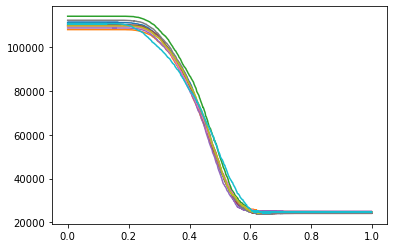

In [12]:
cutoff_candidates = lowest_error_cutoff(10, X_train, y_train, randomized_auc) # Calculate optimal cutoff candidates via 5-fold CV

# Since FP < FN for almost all items (except the ones with item_price = 0) select the 0.75 quantile of the cutoffs 
cutoff_opt = np.quantile(cutoff_candidates, 0.75)
#cutoff_opt = np.mean(cutoff_candidates)

# Calculate predictions on test set
preds = np.where(randomized_auc.predict_proba(X_test)[:, 1] >= cutoff_opt, 1, 0)

Display custom score using the tuned model and the hold out test set and compare with base performance using the found cutoff

In [16]:
print("Tuned Custom Evaluation Score:", cost_custom_eval(y_test, 1 * preds, X_test).round(5))
print("Base Custom Evaluation Score:", base_perf.round(5))
print("Tuned AUC score:", metrics.roc_auc_score(y_test, preds).round(5))
print("Base AUC Score:", metrics.roc_auc_score(y_test, ref_mod.predict(X_test)).round(5))
print("Monkey Custom Evaluation Score:", cost_custom_eval(y_test, 1* random.choices(np.array([True, False]), k = y_test.shape[0]), X_test).round(5))
print("Monkey AUC Score:", metrics.roc_auc_score(y_test, random.choices(np.array([True, False]), k = y_test.shape[0])).round(5))
print("All negative Custom Evaluation Score:", cost_custom_eval(y_test, np.zeros(len(y_test)), X_test).round(5))
print("All negative AUC Score:", metrics.roc_auc_score(y_test, np.zeros(len(y_test))).round(5))

Tuned Custom Evaluation Score: 106677.881
Base Custom Evaluation Score: 253842.318
Tuned AUC score: 0.50931
Base AUC Score: 0.6545
Monkey Custom Evaluation Score: 289923.263
Monkey AUC Score: 0.49762
All negative Custom Evaluation Score: 106846.542
All negative AUC Score: 0.5


Return feature importance

In [ ]:
quant = pd.Series(randomized_auc.feature_importances_,
                  index = X_train.columns).sort_values(ascending = False).quantile(q = 0.7) # get 70% quantile
importance_trained = pd.Series(randomized_auc.feature_importances_, index = X_train.columns).sort_values(ascending = False)
importance_trained[importance_trained >= quant] # Display only the 30% highest importance values

In [ ]:
quant = pd.Series(randomized_auc.feature_importances_,
                  index = X_train.columns).sort_values(ascending = False).quantile(q = 0.3) # get 70% quantile
importance_trained = pd.Series(randomized_auc.feature_importances_, index = X_train.columns).sort_values(ascending = False)
importance_trained[importance_trained < quant] # Display only the 30% lowest importance values

Save AUC score and custom score into .txt file

In [43]:
perf_auc = metrics.roc_auc_score(y_test, preds)
perf_cust = cost_custom_eval(y_test, 1 * preds, X_test)
sys_time = datetime.now().strftime("%d-%b-%Y (%H:%M)")

In [ ]:
%%script false --no-raise-error
# Initiate .txt and column header, is run once
f = open("results_RS.txt", "w+")
file = open("results_RS.txt", "a")
file.write("\t".join(["Time", "\t\t AUC", "\t Custom Score", "\t Cutoff", "\n"]))
file.close()

In [44]:
file = open("results_RS.txt", "a")
file.write(" ".join([sys_time,"\t", str(perf_auc.round(5)),"\t", str(perf_cust.round(5)), "\t\t", str(cutoff_opt.round(5)), "\n"]))
file.close()

Display best parameters and best score during training

In [45]:
print("Best Parameters:", randomized_auc.get_params())

Best Parameters: {'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.9000000000000001, 'gamma': 1.9479508080081354, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.12902867757724626, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 200, 'n_jobs': 40, 'num_parallel_tree': 1, 'random_state': 321, 'reg_alpha': 0, 'reg_lambda': 2.7667137866636837, 'scale_pos_weight': 1, 'subsample': 0.7999999999999999, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}


Save hyperparameters inside a .txt file

In [ ]:
%%script false --no-raise-error
# Initiate .txt and column header, is run once
f = open("hyperparams.txt", "w+")
file = open("hyperparams.txt", "a")
file.write("Hyperparameters in Dictionary format \n")
file.close()

In [46]:
file = open("hyperparams.txt", "a")
file.write("\t".join([sys_time, str(randomized_auc.get_params()), "\n"]))
file.close()

Create Confusion matrix with probabilites and a custom confusion matrix based on the cost matrix

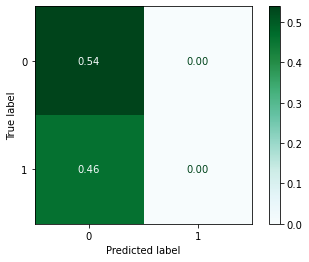

In [47]:
conf_matrix_preds = metrics.confusion_matrix(y_test, preds, normalize = "all")
metrics.ConfusionMatrixDisplay(conf_matrix_preds).plot(cmap = plt.cm.BuGn, values_format = ".2f")

In [48]:
def cust_confusion_matrix(y_true, y_pred, X, normalize = True, rnd = False):
    '''Custom Confusion Matrix with cost matrix
    y_true: 1-d array bool
    y_pred: 1-d array bool
    X: n-d array of data which includes the item price for the respective observations (float)
    normalize: True: Should the custom score be divided by the possible maximum costs?
    rnd: True: Should the normalizing value be calculated using a monkey guessing at random which item will be returned?
    '''
    y_true = 1 * y_true # convert to integer
    y_pred = 1 * y_pred # convert to integer
    
    # Calculate TP, FP, FN and TN
    TP, FP, FN, TN = cost_custom_eval(y_true, y_pred, X, True)
    
    # If clause for random normalization
    if(normalize == True and rnd == True):
        # custom prediction 
        y_random_pred = random.choices(np.array([False, True]), k = y_true.shape[0])
        FP_rel, FN_rel = cost_custom_eval(y_true, y_random_pred, X, True)[1:3] # retrieve FP rate for this case
        results = np.array([[TP, FP/FP_rel],
                            [FN/FN_rel, TN]])
        return(results)
    elif(rnd == False):
        # If clause for normalize
        if(normalize == True):
            y_pred_rel_fp = np.ones(y_true.shape[0]) # Every observation is classified as one
            FP_rel = cost_custom_eval(y_true, y_pred_rel_fp, X) # retrieve FP rate for this case

            y_pred_rel_fn = np.zeros(y_true.shape[0]) # Every observation is classified as zero
            FN_rel = cost_custom_eval(y_true, y_pred_rel_fn, X) # retrieve FN rate for this case
            results = np.array([[TP, FP/FP_rel],
                                [FN/FN_rel, TN]])
            return(results)
        else:
            results = np.array([[TP, FP],
                                [FN, TN]])
            return(results)

Intepretation of a cost matrix based confusion matrix

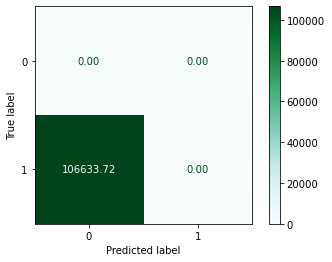

In [49]:
metrics.ConfusionMatrixDisplay(cust_confusion_matrix(y_test, preds, X_test, False)).plot(cmap = plt.cm.BuGn, values_format = ".2f")

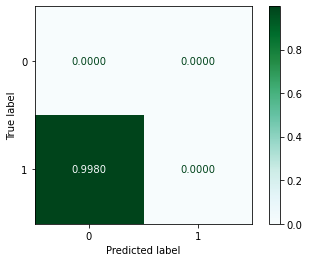

In [50]:
metrics.ConfusionMatrixDisplay(cust_confusion_matrix(y_test, preds, X_test, True)).plot(cmap = plt.cm.BuGn,
                                                                                        values_format = ".4f")

The entry [1,2] describes how our model performs compared to a model which classifies all purchases as returns. The lower this value the lower are the missed profits from not discouraging the customer to place their order. Conversely, the entry [2,1] describes how our model performed compared to a model which flags every purchase as an item which will not be returned. The lower this values the less costs occur from handling the return. 

Finally, we can compare our model in this manner with a model that randomly flags whether an item is returned using the parameter *rnd*.

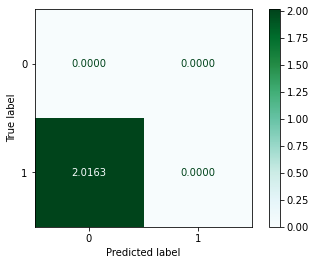

In [51]:
metrics.ConfusionMatrixDisplay(cust_confusion_matrix(y_test, preds, X_test, True, True)).plot(cmap = plt.cm.BuGn,
                                                                                        values_format = ".4f")

Compare with an algorithm that just inteprets the target variable as Bernoulli distributed random variable, i.e. $y_i \thicksim \text{Bern}($p$)$. Our estimator is thus given by $\mathbb{P}(y_i = 1 | X_i) = p$. We display $p \in \{0.25, 0.01\}$ for comparison.

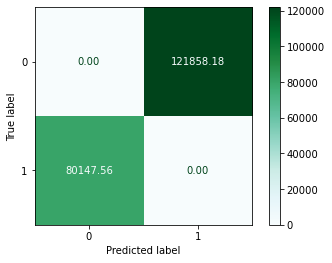

In [52]:
preds_bernoulli = stats.bernoulli.rvs(0.25, loc = 0, size = len(y_test))
metrics.ConfusionMatrixDisplay(cust_confusion_matrix(y_test, preds_bernoulli, X_test, False)).plot(cmap = plt.cm.BuGn, values_format = ".2f")

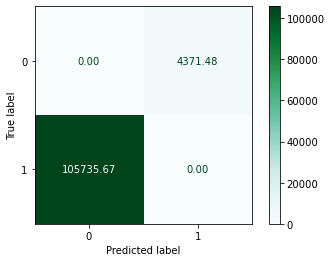

In [53]:
preds_bernoulli = stats.bernoulli.rvs(0.01, loc = 0, size = len(y_test))
metrics.ConfusionMatrixDisplay(cust_confusion_matrix(y_test, preds_bernoulli, X_test, False)).plot(cmap = plt.cm.BuGn, values_format = ".2f")

### Further analytics of predictions.

Create a new data frame with *item_price*, *pred_type* (TP, FN, ...), *y_true*, *y_pred* and the prediction probabilities *pred_proba*.

In [63]:
# Create variable pred_type
def predict_type(x, y):
    if((x == 1) and (y == 1)):
        return("TP")
    elif((x == 0) and (y == 1)):
        return("FP")
    elif((x == 0) and (y == 0)):
        return("TN")
    else:
        return("FN")

pred_type = []

for i in range(y_test.shape[0]):
    pred_type.append(predict_type(1 * y_test[y_test.index[i]], preds[i]))
    #print(y_test[i])
#pred_type = pd.Series(pred_type, index = y_test.index).astype("category")
test = {"item_price" : X_test.item_price.tolist(),
       "pred_type" : pred_type,
       "y_true" : y_test.tolist(),
       "y_pred" : list(preds.astype(bool)),
       "pred_proba" : list(randomized_auc.predict_proba(X_test)[:,1])}
data_post_proc = pd.DataFrame(test,
             index = y_test.index,
             columns = ["item_price", "pred_type", "y_true", "y_pred", "pred_proba"])
data_post_proc.pred_type = data_post_proc.pred_type.astype("category")
data_post_proc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29679 entries, 3548 to 70119
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   item_price  29679 non-null  float64 
 1   pred_type   29679 non-null  category
 2   y_true      29679 non-null  bool    
 3   y_pred      29679 non-null  bool    
 4   pred_proba  29679 non-null  float64 
dtypes: bool(2), category(1), float64(2)
memory usage: 1.8 MB


Display a violinplot for each prediction type with item price as the independent variable.

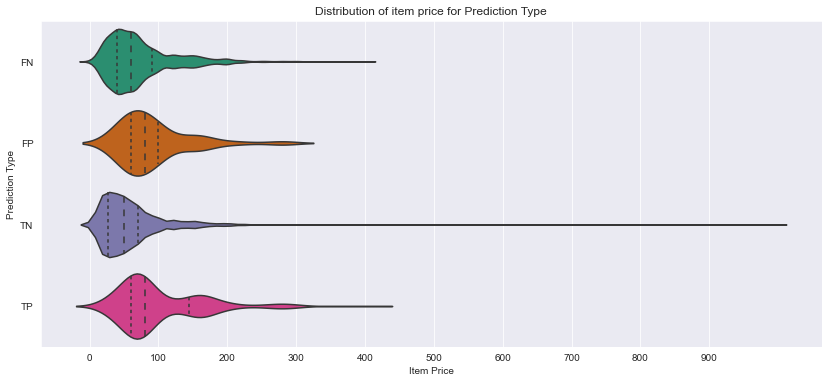

In [101]:
plt.figure(figsize= (14,6))
sns.set_style("darkgrid")
sns.violinplot(y = "pred_type", x = "item_price",
                           split=True, inner="quart",
                           data= data_post_proc, scale = "width", palette = "Dark2")
plt.title("Distribution of item price for Prediction Type")
plt.xlabel("Item Price")
plt.ylabel("Prediction Type")
plt.xticks(np.arange(min(data_post_proc.item_price), max(data_post_proc.item_price), 100))
plt.show()

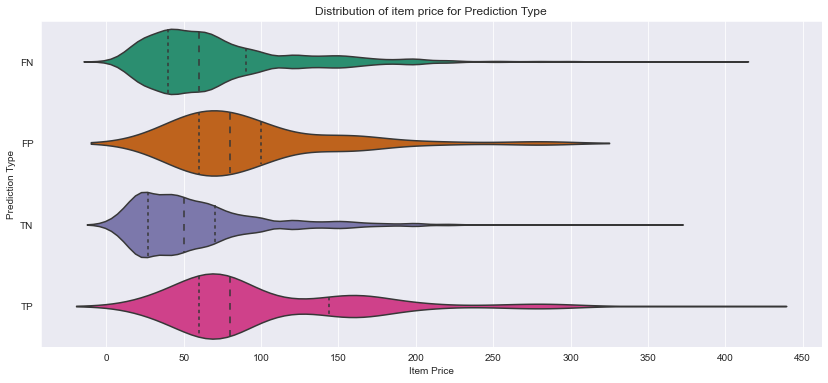

In [104]:
# Without outliers
plt.figure(figsize= (14,6))
sns.set_style("darkgrid")
sns.violinplot(y = "pred_type", x = "item_price",
                           split=True, inner="quart",
                           data= data_post_proc[data_post_proc.item_price <= 500], scale = "width", palette = "Dark2")
plt.title("Distribution of item price for Prediction Type")
plt.xlabel("Item Price")
plt.ylabel("Prediction Type")
plt.xticks(np.arange(min(data_post_proc.item_price), 500, 50))
plt.show()

Heatmap of correlation of prediction probability and item_price

<AxesSubplot:>

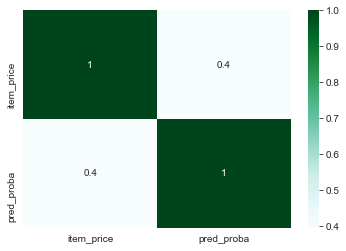

In [113]:
corr =  data_post_proc.loc[:, ["item_price", "pred_proba"]].corr()
#plt.figure(figsize= (8,6))
sns.heatmap(corr, annot = True, cmap="BuGn")

Create .csv of predictions for unknown data set

In [ ]:
data_u = pd.read_pickle('./data/unknown_cleaned_w_dummies')

In [ ]:
preds = randomized_auc.predict_proba(data_u)[:, 1]
predict_unknown = pd.Series(preds, index=data_u["item_id"].index, name='return')
predict_unknown.to_csv("first_pred.csv")